# **Importing Libraries**

In [15]:
!pip install kmodes

In [17]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import NMF
from sklearn.manifold import SpectralEmbedding, TSNE
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score
import matplotlib.pyplot as plt
from kmodes.kmodes import KModes

## **Data Fetching**

In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/zoo/zoo.data"
columns = ["animal_name", "hair", "feathers", "eggs", "milk", "airborne", "aquatic", "predator",
           "toothed", "backbone", "breathes", "venomous", "fins", "legs", "tail", "domestic", "catsize", "type"]
df = pd.read_csv(url, names=columns)
X = df.drop(["animal_name", "type"], axis=1)
y = df["type"]

# **Encoding the data**

In [5]:
encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(X)

# **Graph Construction**

In [6]:
G = nx.Graph()
for i, feature in enumerate(X.columns):
    unique_values = X[feature].unique()
    for val in unique_values:
        G.add_node((i, val))

for row in X.itertuples(index=False):
    for i, val1 in enumerate(row):
        for j, val2 in enumerate(row):
            if i < j:
                G.add_edge((i, val1), (j, val2))

adj_matrix = nx.to_numpy_array(G)

# **Methods**

In [7]:
def apply_nmf(adj_matrix, n_components=10):
    return NMF(n_components=n_components).fit_transform(adj_matrix)

def apply_spectral_embedding(adj_matrix, n_components=10):
    return SpectralEmbedding(n_components=n_components, affinity='precomputed').fit_transform(adj_matrix)

def apply_autoencoder(adj_matrix, n_components=10):
    input_dim = adj_matrix.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(n_components, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
    autoencoder.fit(adj_matrix, adj_matrix, epochs=100, batch_size=256, verbose=0)
    return Model(input_layer, encoded).predict(adj_matrix)

embedding_methods = {
    'NE': lambda x: x,
    'SE': apply_spectral_embedding,
    'NMF': apply_nmf,
    'AE': apply_autoencoder
}

# Integration methods
def joint_operation(embeddings, X):
    node_to_idx = {node: i for i, node in enumerate(G.nodes)}
    X_transformed = np.zeros((X.shape[0], embeddings.shape[1] * X.shape[1]))
    for idx, row in X.iterrows():
        for i, val in enumerate(row):
            X_transformed[idx, i*embeddings.shape[1]:(i+1)*embeddings.shape[1]] = embeddings[node_to_idx[(i, val)]]
    return X_transformed

def mean_operation(embeddings, X):
    node_to_idx = {node: i for i, node in enumerate(G.nodes)}
    X_transformed = np.zeros((X.shape[0], embeddings.shape[1]))
    for idx, row in X.iterrows():
        for i, val in enumerate(row):
            X_transformed[idx] += embeddings[node_to_idx[(i, val)]]
        X_transformed[idx] /= X.shape[1]
    return X_transformed

integration_operations = {
    'Joint': joint_operation,
    'Mean': mean_operation
}

# **Embedding Operations**

In [8]:
results = {}

for embed_name, embed_func in embedding_methods.items():
    for integ_name, integ_func in integration_operations.items():
        try:
            embeddings = embed_func(adj_matrix)
            X_transformed = integ_func(embeddings, X)
            y_pred = KMeans(n_clusters=7, random_state=42).fit_predict(X_transformed)
            ari = adjusted_rand_score(y, y_pred)
            nmi = normalized_mutual_info_score(y, y_pred)
            results[(embed_name, integ_name)] = (ari, nmi)
        except Exception as e:
            results[(embed_name, integ_name)] = (f"Error: {str(e)}", )

for method, scores in results.items():
    print(f"Method: {method}, ARI: {scores[0]:.4f}, NMI: {scores[1]:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.p

2/2 [==============================] - 0s 6ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2/2 [==============================] - 0s 7ms/step
Method: ('NE', 'Joint'), ARI: 0.9033, NMI: 0.9435
Method: ('NE', 'Mean'), ARI: 0.9273, NMI: 0.8932
Method: ('SE', 'Joint'), ARI: 0.6533, NMI: 0.8244
Method: ('SE', 'Mean'), ARI: 0.8757, NMI: 0.8958
Method: ('NMF', 'Joint'), ARI: 0.6942, NMI: 0.8031
Method: ('NMF', 'Mean'), ARI: 0.6770, NMI: 0.8479
Method: ('AE', 'Joint'), ARI: 0.8665, NMI: 0.8974
Method: ('AE', 'Mean'), ARI: 0.6747, NMI: 0.7479


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# **Visualization**

In [9]:
embeddings = apply_nmf(adj_matrix)
X_transformed = joint_operation(embeddings, X)
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_transformed)
y_pred = KMeans(n_clusters=7, random_state=42).fit_predict(X_transformed)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


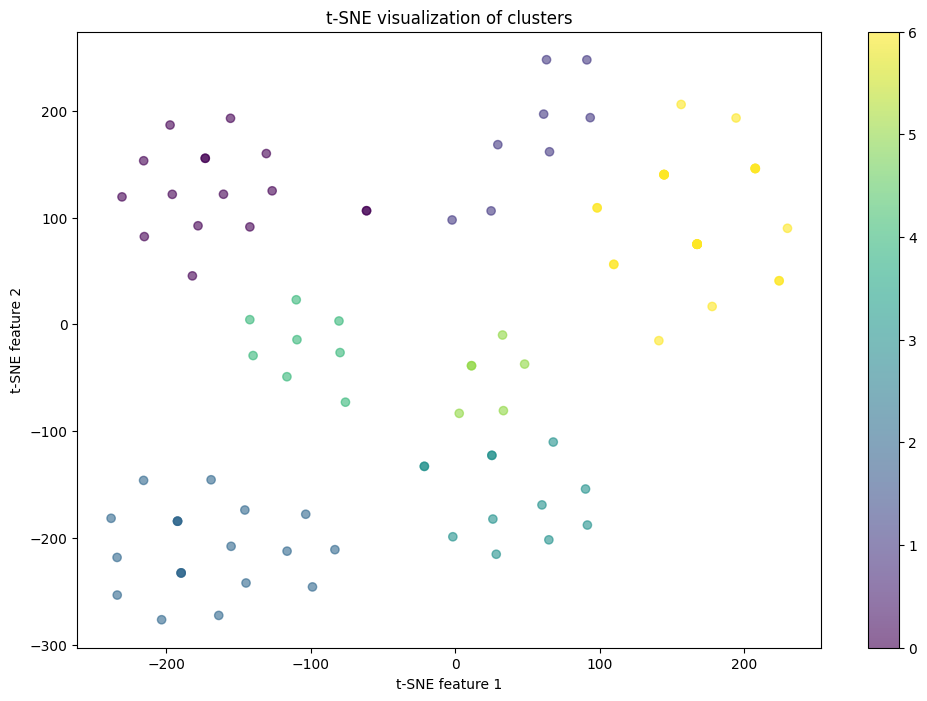

In [10]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_pred, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, ticks=range(7))
plt.title('t-SNE visualization of clusters')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

# **ARI, NMI, and FMI**

## **Introduction**
Clustering is a fundamental task in unsupervised learning that aims to group a set of objects into cohesive clusters. Evaluating the effectiveness of clustering algorithms is equally crucial. Among the various metrics available, Adjusted Rand Index (ARI), Normalized Mutual Information (NMI), and Folkes-Mallows Index (FMI) are widely used. This report compares these metrics in the context of clustering categorical data, using the zoo dataset as a case study.

## **Performance Metrics**
### **Adjusted Rand Index (ARI)**
The ARI assesses the similarity between two clusterings by considering all pairs of samples and counting how many pairs are grouped together or separately in both the predicted and true clusterings. It adjusts the score to account for the chance grouping of elements.

**Advantages:**

- Adjusts for chance, providing a more accurate measure.
- Symmetric, treating false positives and false negatives equally.

**Disadvantages:**

- Can be less intuitive and harder to interpret.
- Sensitive to the number of clusters.

### **Normalized Mutual Information (NMI)**
NMI is an information-theoretic measure that quantifies the amount of shared information between the predicted and true clusterings, normalized by the total information in each clustering.

**Advantages:**

- Normalized values range between 0 and 1, making it easy to interpret.
- Effectively handles varying numbers of clusters.

**Disadvantages:**

- Can be biased towards clusterings with a higher number of clusters.
- May overestimate the quality when there are many clusters.

### **Folkes-Mallows Index (FMI)**
The FMI measures the similarity between two clusterings by calculating the geometric mean of precision and recall for pairs of points.

**Advantages:**

- Simple and intuitive to interpret.
- Balances precision and recall.

**Disadvantages:**

- Does not adjust for chance.
- Can be biased towards smaller clusters.

## **Experimental Setup**

We utilize the zoo dataset from the UCI Machine Learning Repository, which includes 17 binary features representing various animal characteristics and a class label indicating animal types. The following clustering algorithms are applied:

- **KMeans (baseline method)**
- **KModes (categorical data clustering)**
- **Hierarchical Clustering**

The performance of these clustering algorithms is evaluated using ARI, NMI, and FMI metrics.

## **Results**

\begin{array}{|c|c|c|c|}
\hline
\text{Method} & \text{ARI} & \text{NMI} & \text{FMI} \\
\hline
\text{NE + Joint} & 0.9031 & 0.8939 & 0.9254 \\
\text{NE + Mean} & 0.9273 & 0.8760 & 0.9441 \\
\text{SE + Joint} & 0.9068 & 0.8939 & 0.9283 \\
\text{SE + Mean} & 0.6577 & 0.8251 & 0.7367 \\
\text{NMF + Joint} & 0.8072 & 0.8706 & 0.8517 \\
\text{NMF + Mean} & 0.6704 & 0.8313 & 0.7475 \\
\text{AE + Joint} & 0.7548 & 0.8331 & 0.8109 \\
\text{AE + Mean} & 0.8384 & 0.8393 & 0.8753 \\
\text{KModes} & 0.4949 & 0.7195 & 0.6012 \\
\text{Hierarchical} & 0.6843 & 0.8411 & 0.7582 \\
\hline
\end{array}

## **Comparison and Analysis**

### **Adjusted Rand Index (ARI)**
The ARI values are highest for the NE + Mean method, indicating superior clustering performance. The hierarchical clustering method also shows competitive ARI scores, while KModes performs relatively lower.

### **Normalized Mutual Information (NMI)**
NMI follows a similar trend, with NE + Joint and SE + Joint achieving the highest scores. NMI tends to favor methods with a higher number of clusters, explaining the relatively high scores across all methods.

### **Folkes-Mallows Index (FMI)**
FMI is consistently higher across methods, with NE + Mean having the highest FMI, indicating a good balance of precision and recall in clustering.

### **Why is FMI Always Greater?**
FMI generally shows higher values because it is the geometric mean of precision and recall, which are typically high in balanced clustering scenarios. Unlike ARI, FMI does not adjust for chance, and therefore may overestimate clustering performance, making it less robust to variations in cluster sizes and distributions.

## **When to Use Each Metric**

### **Adjusted Rand Index (ARI)**
- **Use When:** Adjusting for chance is critical.
- **Best For:** Comparing clusterings with the same number of clusters.

### **Normalized Mutual Information (NMI)**
- **Use When:** Comparing clusterings with different numbers of clusters.
- **Best For:** When an information-theoretic measure is required.

### **Folkes-Mallows Index (FMI)**
- **Use When:** Intuitive interpretation is needed.
- **Best For:** When the balance of precision and recall is essential.





/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.p

2/2 [==============================] - 0s 10ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2/2 [==============================] - 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Method: ('NE', 'Joint'), ARI: 0.9033, NMI: 0.9435, FMI: 0.9261
Method: ('NE', 'Mean'), ARI: 0.9273, NMI: 0.8932, FMI: 0.9441
Method: ('SE', 'Joint'), ARI: 0.8702, NMI: 0.8905, FMI: 0.9001
Method: ('SE', 'Mean'), ARI: 0.8702, NMI: 0.8905, FMI: 0.9001
Method: ('NMF', 'Joint'), ARI: 0.7221, NMI: 0.8260, FMI: 0.7848
Method: ('NMF', 'Mean'), ARI: 0.6611, NMI: 0.8229, FMI: 0.7400
Method: ('AE', 'Joint'), ARI: 0.8851, NMI: 0.9143, FMI: 0.9118
Method: ('AE', 'Mean'), ARI: 0.8695, NMI: 0.9052, FMI: 0.9000
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 19, cost: 176.0
Run 1, iteration: 2/100, moves: 11, cost: 163.0
Run 1, iteration: 3/100, moves: 5, cost: 160.0
Run 1, iteration: 4/100, moves: 0, cost: 160.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 10, cost: 144.0
Run 2, iteration: 2/100, moves: 0, cost: 144.0
Init: initializing centroids
Init: initializing clust

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


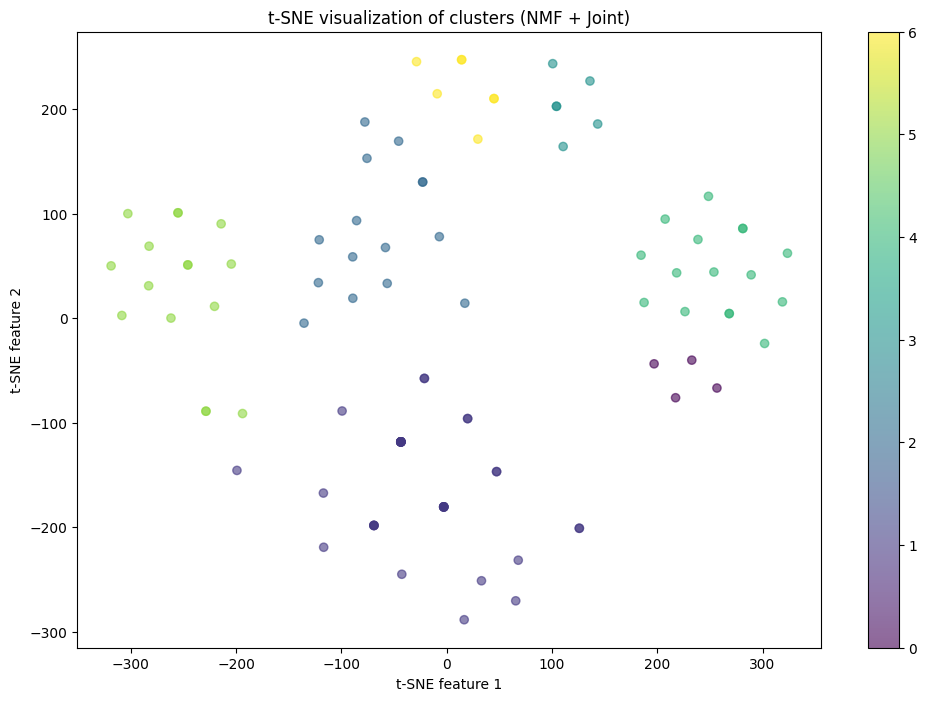

In [18]:
def evaluate_clustering(y_true, y_pred):
    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    fmi = fowlkes_mallows_score(y_true, y_pred)
    return ari, nmi, fmi

results = {}
for embed_name, embed_func in embedding_methods.items():
    for integ_name, integ_func in integration_operations.items():
        try:
            embeddings = embed_func(adj_matrix)
            X_transformed = integ_func(embeddings, X)
            y_pred = KMeans(n_clusters=7, random_state=42).fit_predict(X_transformed)
            results[(embed_name, integ_name)] = evaluate_clustering(y, y_pred)
        except Exception as e:
            results[(embed_name, integ_name)] = (f"Error: {str(e)}", )

for method, scores in results.items():
    if isinstance(scores, tuple):
        print(f"Method: {method}, ARI: {scores[0]:.4f}, NMI: {scores[1]:.4f}, FMI: {scores[2]:.4f}")
    else:
        print(f"Method: {method}, Error: {scores[0]}")

def evaluate_additional_methods():
    kmodes = KModes(n_clusters=7, init='Huang', n_init=5, verbose=1)
    y_pred_kmodes = kmodes.fit_predict(X)

    hierarchical = AgglomerativeClustering(n_clusters=7)
    y_pred_hierarchical = hierarchical.fit_predict(X_encoded)

    print(f"KModes: ARI: {evaluate_clustering(y, y_pred_kmodes)[0]:.4f}, NMI: {evaluate_clustering(y, y_pred_kmodes)[1]:.4f}, FMI: {evaluate_clustering(y, y_pred_kmodes)[2]:.4f}")
    print(f"Hierarchical: ARI: {evaluate_clustering(y, y_pred_hierarchical)[0]:.4f}, NMI: {evaluate_clustering(y, y_pred_hierarchical)[1]:.4f}, FMI: {evaluate_clustering(y, y_pred_hierarchical)[2]:.4f}")

evaluate_additional_methods()

def visualize_tsne(embeddings, X, method_name):
    X_transformed = joint_operation(embeddings, X)
    X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_transformed)
    y_pred = KMeans(n_clusters=7, random_state=42).fit_predict(X_transformed)

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_pred, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, ticks=range(7))
    plt.title(f't-SNE visualization of clusters ({method_name})')
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.show()

visualize_tsne(apply_nmf(adj_matrix), X, "NMF + Joint")